# Idéer til R&D endogen vækst modeller med et dynamisk element 

In [1]:
import matplotlib.pyplot as plt
from scipy import optimize
import numpy as np
import sympy as sm
sm.init_printing(use_unicode=True)

In [2]:
def plot(x,y):
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.plot(x,y)

# mikro problemet 
Optimal arbejdsfordeling

I hver periode, t, skal den enkelte repræsentative forbruger vælge hvor meget han vil arbejde med produktion og arbejde med forskning. Produktion bruges til forbrug i periode t og kapitalopsparing som bidrag til fremtidig produktion. Forskning øger produktiviten i fremtidige perioder .

In [3]:
#valgmuligheder:
# andelen af mulig arbejdstid som bruges på forskning:
sr = sm.symbols('s_Rt')
# I starten antages kapitalopspsparingsraten at være konstant
sk = sm.symbols('s_Kt')

In [4]:
# Ud fra de valg nogle udfald
# Først defineres variable
l = sm.symbols('L_{t}')
ly = sm.symbols('L_{Yt}')
la = sm.symbols('L_{At}')
alpha = sm.symbols('alpha')
k =sm.symbols('K_{t}')
k1 = sm.symbols('K_{t+1}')
y = sm.symbols('Y_{t}')
c = sm.symbols('C')
ct = sm.symbols('C_{t}')
a = sm.symbols('A_{t}')
a1 = sm.symbols('A_{t+1}')
r = sm.symbols('r')

#Greek:
rho = sm.symbols('rho')
beta = sm.symbols('beta')
alpha = sm.symbols('alpha')
phi = sm.symbols('phi')
delta = sm.symbols('delta')
theta = sm.symbols('theta')

t = sm.symbols('t')

# Functions:
uc = sm.Function('u')(ct) 
u = sm.Function('U')(c)

Nyttefunktion:

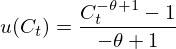

In [5]:
sm.Eq(uc,(ct**(1-theta)-1)/(1-theta))

In [6]:
hello = sm.Limit((ct**(1-theta)-1)/(1-theta),theta,1)

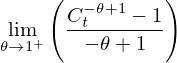

In [7]:
hello

In [8]:
hello.doit()

In [9]:
sm.diff(ct**(1-rho),rho)

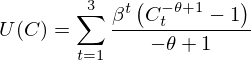

In [10]:
sm.Eq(u,sm.Sum(beta**t*(ct**(1-theta)-1)/(1-theta),(t,1,3)))

*** Value of capital leftover capital ***

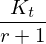

In [11]:
k/(1+r)

In [12]:
sm.Eq(y,a*k**alpha*(l*(1-sr))**(1-alpha))

In [13]:
mpl = sm.Derivative(a*k**alpha*(l*(1-sr))**(1-alpha),k)

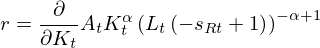

In [14]:
sm.Eq(r,mpl)

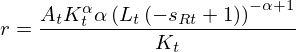

In [15]:
sm.Eq(r,mpl.doit())

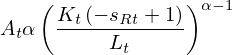

In [16]:
a*alpha*((k/l*(1-sr))**(alpha-1))

Betingelser i produktion:

In [17]:
sm.Eq(c,sk*y)

Tidshorisonts betingelser

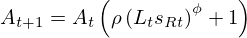

In [18]:
sm.Eq(a1,a*(1+rho*(l*sr)**phi))

In [19]:
sm.Eq(k1,sk*y+(1-delta)*k)

In [20]:
sm.init_printing(use_unicode=False)

In [21]:
def utility(c,theta):
    ''' Utility function for consumption including the limit case for rho->1 '''
    if c<0:
        raise error
    if rho == 1:
        return np.log(c)
    else:
        return (c**(1-theta)-1)/(1-theta)

def total_utility(c, beta, theta, k):
    '''
    Sums utility for c for multiple years
    c is an array 
    '''
    t_u = 0
    for i,ct in enumerate(c):
        t_u += beta**i*utility(ct,theta)
    t_u += beta**(len(c))*utility(ct,theta)
    return t_u

def prod(k,l,alpha,b):
    return b*k**alpha*l**(1-alpha)

In [22]:
def tot_ut_sk(sk,t, k0, b, beta, alpha, theta, delta, detail=False):
    '''
    Returns utitlity for  given period 
    depending on initial amount of kapital, k0,
    and a fixed savingsrate, sk, for all periods 
    '''
    k_short = np.empty(t)
    c_short = np.empty(t)
    y_short = np.empty(t)
    k_short[0] = k0
    for i in range(t):
        y_short[i] = prod(k_short[i],l,alpha,b)
        c_short[i]=(1-sk)*y_short[i]
        if i+1<t:
            k_short[i+1]=sk*y_short[i]+(1-delta)*k_short[i] 
    if detail:
        return k_short,c_short,y_short
    else:
        return total_utility(c_short,beta,theta,k_short[-1])

def opt_sk(t, b, beta, delta, alpha, theta, k0):
    '''Finds optimal fixed savings rate, sk, 
    for maximal total utility '''
    obj = lambda sk: -tot_ut_sk(sk,t,k0, b, beta, alpha, theta, delta)
    res = optimize.minimize_scalar(obj, alpha, method='bounded',bounds=[0,1])
    return res.x

In [23]:
theta = 0.5
alpha = 1/3
delta = 0.05

In [24]:
t = 1000
b = 10
k0 = 10
l = 1
beta = 0.9

In [25]:
obj = lambda sk: -tot_ut_sk(sk,t, k0, b, beta,alpha, theta, delta)
sk0 = [0.3]
res = optimize.minimize(obj, sk0, method='Nelder-Mead')
print(f'Optimal sk = {res.x[0]:.4f}, with total utility = {-res.fun:.4f}')

Optimal sk = 0.2419, with total utility = 84.1670


In [26]:
obj = lambda sk: -tot_ut_sk(sk,t, k0, b, beta,alpha, theta, delta)
sk0 = [0.3]
res = optimize.minimize_scalar(obj, sk0, method='bounded',bounds=[0,1])
print(f'Optimal sk = {res.x:.4f}, with total utility = {-res.fun:.4f}')

Optimal sk = 0.2420, with total utility = 84.1670


In [27]:
n = 100
ks = np.linspace(0.1,200,n)
sks = np.zeros(n)
for i,k in enumerate(ks):
    sks[i] = opt_sk(t, b, beta,delta,alpha,theta,k)

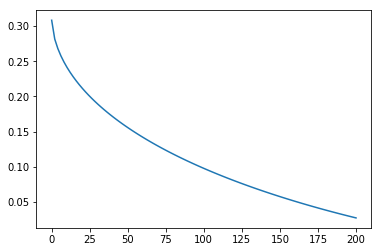

In [28]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(ks,sks)

# Hvad hvis forskellige opsparingsrater kan vælges hvert år?

In [29]:
def tot_ut_multiple_sks(sks, k0, b, beta, theta, alpha, delta, vector=False):
    '''
    Finds total utitilty for a set of years with a savingsrate for each year
    '''
    t = len(sks)
    k_short = np.empty(t)
    c_short = np.empty(t)
    y_short = np.empty(t)
    k_short[0] = k0
    for i in range(t):
        y_short[i] = prod(k_short[i],l,alpha,b)
        c_short[i]=(1-sks[i])*y_short[i]
        if i+1<t:
            k_short[i+1]=sks[i]*y_short[i]+(1-delta)*k_short[i]
    if vector==False:
        return total_utility(c_short, beta, theta, k_short[-1])
    elif vector==True:
        return total_utility(c_short, beta, theta, k_short[-1]), y_short, c_short, k_short

In [30]:
theta = 0.9
alpha = 1/3
delta = 0.05
beta = 1
b = 100
k0 = 20
l = 1

In [31]:
sks = [0.4, 0.3201, 0.2988, 0.9, 0.]
tot_ut_multiple_sks(sks, k0, b, beta, theta, alpha,delta)

In [32]:
t = 200
obj = lambda sks: -tot_ut_multiple_sks(sks, k0, b, beta, theta, alpha, delta)
sks0 = np.full(t,0.3)
sks0[-1] = 0
bounds = np.full((t,2),[0,1])


res = optimize.minimize(obj, sks0, method='SLSQP', bounds=bounds)

print(f'Optimal sk')
np.set_printoptions(precision=4,suppress=True)
print(res.x)
print('Total utility:')
print(f'{-res.fun:.4f}')

Optimal sk
[0.6413 0.6466 0.6271 0.6044 0.583  0.5634 0.5458 0.5299 0.5154 0.5023
 0.4904 0.4794 0.4693 0.4601 0.4516 0.4437 0.4365 0.4297 0.4234 0.4177
 0.4122 0.4072 0.4026 0.3982 0.3941 0.3903 0.3868 0.3835 0.3804 0.3775
 0.3747 0.3722 0.3698 0.3676 0.3655 0.3635 0.3617 0.36   0.3584 0.3569
 0.3555 0.3541 0.3529 0.3517 0.3506 0.3495 0.3485 0.3476 0.3468 0.346
 0.3453 0.3445 0.3439 0.3432 0.3426 0.3421 0.3415 0.341  0.3406 0.3401
 0.3397 0.3393 0.3389 0.3386 0.3383 0.338  0.3377 0.3374 0.3372 0.3369
 0.3367 0.3365 0.3362 0.3361 0.3359 0.3357 0.3355 0.3354 0.3352 0.3351
 0.3349 0.3348 0.3347 0.3346 0.3345 0.3343 0.3342 0.3341 0.334  0.3339
 0.3338 0.3337 0.3336 0.3336 0.3334 0.3333 0.3332 0.3332 0.3331 0.333
 0.3329 0.3328 0.3327 0.3326 0.3325 0.3324 0.3322 0.3321 0.332  0.3319
 0.3318 0.3316 0.3315 0.3313 0.3312 0.331  0.3308 0.3307 0.3305 0.3303
 0.33   0.3298 0.3296 0.3294 0.3291 0.3288 0.3285 0.3282 0.3278 0.3274
 0.3271 0.3266 0.3262 0.3257 0.3252 0.3247 0.3241 0.3236 0.3229 0.32

In [33]:
def optimal_sks(t, b, beta, delta, alpha, theta, k0, first=True):
    obj = lambda sks: -tot_ut_multiple_sks(sks, k0, b, beta, theta, alpha, delta)
    sks0 = np.full(t,0.3)
    sks0[-1] = 0
    bounds = np.full((t,2),[0,1])
    res = optimize.minimize(obj, sks0, method='SLSQP', bounds=bounds)
    if res.success == False:
        print('Optimization was sadly not succesfull')
    elif first:
        return res.x[0]
    else:
        return res.x

In [34]:
theta = 0.9
alpha = 1/3
delta = 0.05
beta = 1
b = 2
beta = 0.99
k0 = 40
l = 1
t = 100

In [35]:
opt_sk(t, b, beta, delta, alpha, theta, k0)

In [36]:
sks = optimal_sks(t, b, beta, delta, alpha, theta, k0,first=False)

In [37]:
total, y, c, k = tot_ut_multiple_sks(sks, k0, b, beta, theta, alpha, delta, vector=True)

In [38]:
sks_alt = [alpha for i in list(range(t))]
total_alt, y_alt, c_alt, k_alt = tot_ut_multiple_sks(sks_alt, k0, b, beta, theta, alpha, delta, vector=True)

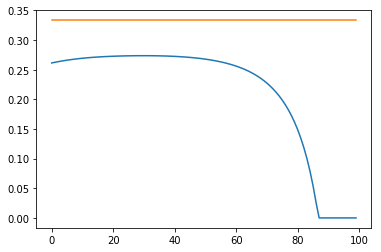

In [39]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(list(range(t)),sks)
ax.plot(list(range(t)),sks_alt)

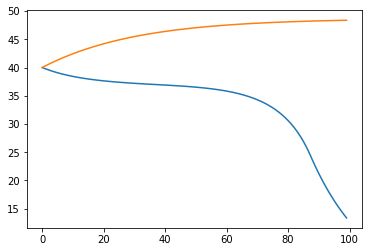

In [40]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(list(range(t)),k)
ax.plot(list(range(t)),k_alt)

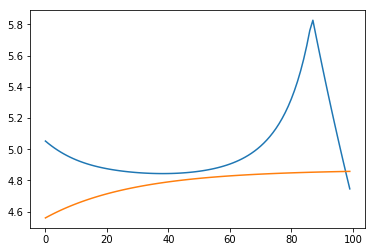

In [41]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(list(range(t)),c)
ax.plot(list(range(t)),c_alt)

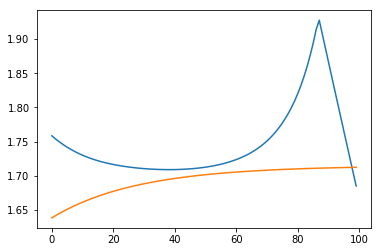

In [42]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(list(range(t)), [utility(ct,theta)for ct in c])
ax.plot(list(range(t)), [utility(ct,theta)for ct in c_alt])

In [43]:
ks = np.linspace(0.1,100,100)
sks1 = np.empty(100)

for i, k in enumerate(ks):
    sks1[i] = optimal_sks(t, b, beta, delta, alpha, theta, k)

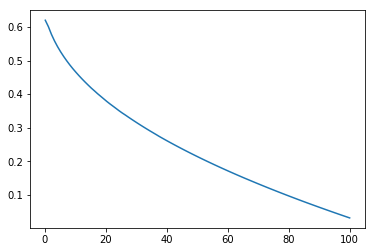

In [44]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(ks,sks1)

In [45]:
ks = np.linspace(1,600,50)
sks1 = np.empty(50)

for i, k in enumerate(ks):
    sks1[i] = optimal_sks(t, b, beta, delta, alpha, theta, k)

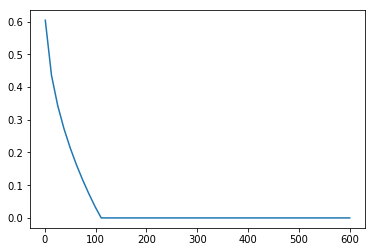

In [46]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(ks,sks1)

# Need for speed

In [47]:
import time

# Makro sammensætning

In [48]:
sm.init_printing(use_unicode=True)

In [49]:
#valgmuligheder:
# andelen af mulig arbejdstid som bruges på forskning:
sr = sm.symbols('s_Rt')
# I starten antages kapitalopspsparingsraten at være konstant
sk = sm.symbols('s_Kt')

# Ud fra de valg nogle udfald
# Først defineres variable
l = sm.symbols('L_{t}')
alpha = sm.symbols('alpha')
k =sm.symbols('K_{t}')
k1 = sm.symbols('K_{t+1}')
y = sm.symbols('Y_{t}')
c = sm.symbols('C')
ct = sm.symbols('C_{t}')
a = sm.symbols('A_{t}')
a1 = sm.symbols('A_{t+1}')
r = sm.symbols('r')

#Greek:
rho = sm.symbols('rho')
beta = sm.symbols('beta')
alpha = sm.symbols('alpha')
phi = sm.symbols('phi')
delta = sm.symbols('delta')
lambd = sm.symbols('lambda')
theta = sm.symbols('theta')

t = sm.symbols('t')

# Functions:
uc = sm.Function('u')(ct) 
u = sm.Function('U')(c)

In [50]:
sm.Eq(y,a*k**alpha*(l*(1-sr))**(1-alpha))

In [51]:
sm.Eq(k1,sk*y+(1-delta)*k)

In [52]:
sm.Eq(a1,a+rho*a**phi*(l*sr)**lambd)

In [61]:
# parameters:
alpha = 1/3
delta = 0.05
rho = 0.9
phi = 0.1
lambd = 0.1
n=0

# fixed parameters
sr = 0.05
sk = 0.2

# starting values:
l0 = 100
k0 = 1000
a0 = 1000

In [57]:
# funktiions
def prod(a,k,l,sr,alpha):
    return k**alpha*(a*(1-sr)*l)**(1-alpha)
def capitalakku(a,k,l,sr,sk,alpha,delta):
    return prod(a,k,l,sr,alpha)*sk+(1-delta)*k
def research(a,sr,l,rho,phi):
    return a+rho*a**phi*(l*sr)**lambd

In [58]:
def solowwalk(k0,a0, l0, n, sr, sk, alpha, delta, rho, phi, t):
    k_path=np.array([k0])
    a_path=np.array([a0])
    l_path = [(1+n)**i for i in list(range(end))]
    
    for i in range(1,t):
        k_plus = capitalakku(a_path[i-1],k_path[i-1],l_path[i-1],sr,sk,alpha,delta)
        a_plus = research(a_path[i-1],sr,l_path[i-1],rho,phi)
        
        np.append(k_path, k_plus)
        np.append(a_path, a_plus)
    k_tilde_path = k_path/(a_path*l_path)    
    return a_path, k_path, k_tilde_path

In [59]:
t=10000

In [ ]:
plot(range(t),np.log(a_path))

In [ ]:
end = 10000
ks = np.empty(end)
ys = np.empty(end)
ls = [(1+n)**i for i in list(range(end))]
ks[0] = k0
ats = np.zeros(end)
ats[0] = a0
margin = 1e-3
ys[0] = prod(ats[0],ks[0],ls[0],sr,alpha)
ks[1]   = capitalakku(ats[0],ks[0],ls[0],sr,sk,alpha,delta)
ats[1] = research(ats[0],sr,ls[0],rho,phi)

In [ ]:

t = 1
while True:
    ys[t] = prod(ats[t],ks[t],ls[t],sr,alpha)
    if -margin<ys[t]-ys[t-1]<margin:
        k_tilde = ks[t]/(ats[t]*ls[t])
        y_tilde = ys[t]/(ats[t]*ls[t])
        print(f'Succesful convergens')
        print(f'Periode = {t}')
        print(f'y_tilde = {y_tilde:.4f}')
        print(f'k_tilde = {k_tilde:.4f}')
        break
    ks[t+1]   = capitalakku(ats[t],ks[t],ls[t],sr,sk,alpha,delta)
    ats[t+1] = research(ats[t],sr,ls[t],rho,phi)
    t += 1 
    if t+1 == end:
        print('no convergens')
        print(t)
        break

In [ ]:
ks_small = ks/ls

In [ ]:
plot(range(t),ks_small[:t])

Simulation

In [ ]:
t = 1000
ys = np.zeros(t)
ks = np.zeros(t)
ls = [(1+n)**i for i in list(range(t))]
ks[0] = k0
ats = np.zeros(t)
ats[0] = a0

In [ ]:
for i in list(range(t)):
    ys[i] = prod(ats[i],ks[i],ls[i],sr,alpha)
    if i+1<t:
        ks[i+1]   = capitalakku(ats[i],ks[i],ls[i],sr,sk,alpha,delta)
        ats[i+1] = research(ats[i],sr,ls[i],rho,phi)
    

In [ ]:
y_small = ys/ls
y_tildes = y_small/ats
log_ys = np.log(ys)
ks_small = ks/ls
ks_tilde = ks_small/ats
log_ats = np.log(ats)
log_ls = np.log(ls)
log_ks = np.log(ks)
log_ks_small = np.log(ks_small)

In [ ]:
plot(range(t),ks_small)

In [ ]:
plot(range(t),log_ats)
plot(range(t),log_ls)
plot(range(t),log_ks)
plot(range(t),log_ys)

# Makro med mikro-valg

In [ ]:
rho = 0.5
alpha = 1/3
delta = 0.05
beta = 0.5
b = 10
l = 1
t= 50
k0 = 10
l = 1
beta = 0.9

In [ ]:
opt_sk(t, b, beta,delta,alpha,rho,k0)

In [ ]:
t_store = 25
c = np.empty(t_store)
k = np.empty(t_store)
k[0] = 1
y = np.empty(t_store)
sks = np.empty(t_store)

In [ ]:
for i in range(t_store):
    k0 = k[i]
    sks[i] = opt_sk(t,b, beta,delta,alpha,rho,k0)
    if i+1<t_store:
        k[i+1] = sks[i]*prod(k[i],l,alpha,b)-delta*k[i]

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(range(t_store),sks)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(range(t_store),k)

In [ ]:
def capakku(k1,l,sk,delta,alpha,b):
    return sk*prod(k1,l,alpha,b)-delta*k1

In [ ]:
t=10
alpha = 1/3
delta = 0.05
sk_fix = 1/3
n= 0.01

In [ ]:
ks = np.empty(t)
ys = np.empty(t)
l = 1
ks[0]= 5.6

In [ ]:
for i in range(t):
    ys[i]=prod(ks[i],l,alpha,b)
    if i+1<t:
        ks[i+1] = capakku(ks[i],l,sk_fix,delta,alpha,b)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(range(t),ys)